In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ml_help
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from time import time
sns.set_theme()

In [2]:
metrics_available = os.listdir("./metrics")
METRICS_DONE = "015_gardiner_count_only_cv_metrics.csv.zip" in metrics_available and "015_gardiner_count_only_metrics.csv.zip" in metrics_available

# Load data

In [3]:
df = pd.read_csv("./data/gardiner_count.csv.zip")
df.head(3)

,datetime_bin,volume_15min,number_of_lanes,direction,month,day,day_of_week,hour,minute,dist_from_mid_point
0,2022-08-11 15:00:00+00:00,160,3,W,August,11,Thursday,15,0,4.887837
1,2022-08-11 15:00:00+00:00,170,3,E,August,11,Thursday,15,0,0.474912
2,2022-08-11 15:00:00+00:00,169,3,E,August,11,Thursday,15,0,-0.635254


In [4]:
df.drop(["datetime_bin"],axis=1,inplace=True)
df.head(3)

,volume_15min,number_of_lanes,direction,month,day,day_of_week,hour,minute,dist_from_mid_point
0,160,3,W,August,11,Thursday,15,0,4.887837
1,170,3,E,August,11,Thursday,15,0,0.474912
2,169,3,E,August,11,Thursday,15,0,-0.635254


In [5]:
categorical_feats = ["direction","month","day_of_week"]
    
transformed_df = pd.get_dummies(df, columns=categorical_feats)
transformed_df = transformed_df.astype("float32")
transformed_df.head(3)

,volume_15min,number_of_lanes,day,hour,minute,dist_from_mid_point,direction_E,direction_W,month_August,month_December,...,month_November,month_October,month_September,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,160.0,3.0,11.0,15.0,0.0,4.887837,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,170.0,3.0,11.0,15.0,0.0,0.474912,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,169.0,3.0,11.0,15.0,0.0,-0.635254,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
X = transformed_df.drop("volume_15min",axis=1)
y = transformed_df["volume_15min"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Load models

In [7]:
metrics = pd.read_csv("./metrics/014_best_metrics.csv.zip")
metrics

,model,r2,mae,mse,rmse,mape,time_to_fit,time_to_predict,ttf
0,XGBoost,0.970803,45.752130,4538.633000,67.369380,1.584660e+15,13.256450,0.130426,NaN
1,Random Forest,0.937069,65.349060,9782.534180,98.906693,2.955529e+15,NaN,NaN,1.311731
2,MLP,0.924641,74.008790,11714.545000,108.233750,3.004927e+15,NaN,NaN,171.602071
3,Decision Tree,0.839230,115.802268,24991.620848,158.087384,4.068522e+15,0.267455,0.011391,NaN


## XGBoost

### Run CV

In [8]:
import xgboost as xgb

params = ml_help.params_to_dict("013_xgboost")

In [9]:
params['predictor'] = 'cpu_predictor'
params['tree_method'] = 'hist'
    
xgboost_pipeline = make_pipeline(StandardScaler(),xgb.XGBRegressor(**params))

if not METRICS_DONE:
    
    xgb_cv_metrics = ml_help.run_stratified_kfold("XGBoost",xgboost_pipeline,X_train,y_train)
    xgb_cv_metrics

### Run test using previously unseen data

In [10]:
xgboost_pipeline = make_pipeline(StandardScaler(),xgb.XGBRegressor(**params))

start = time()
pipe = xgboost_pipeline.fit(X_train,y_train)
end = time()

y_pred = pipe.predict(X_test)

xgb_metrics = ml_help.get_metrics_reg("XGBoost",y_test,y_pred)
xgb_metrics["time_to_fit"] = end-start
xgb_metrics

{'model': 'XGBoost',
 'r2': 0.9681590541414763,
 'mae': 47.989197,
 'mse': 4986.042,
 'rmse': 70.61191,
 'mape': 2479787100000000.0,
 'time_to_fit': 21.217866897583008}

In [22]:
data = X_test.copy(deep=True)
data["Actual"] = y_test
data["Pred."] = y_pred
data.sort_index(inplace=True)
data_dec = data[(data["month_December"] == 1) & (data["day"] == 29)]
data_dec

,number_of_lanes,day,hour,minute,dist_from_mid_point,direction_E,direction_W,month_August,month_December,month_January,...,month_September,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,Actual,Pred.
140115,4.0,29.0,0.0,0.0,-3.325903,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,346.0,342.571625
140116,2.0,29.0,0.0,0.0,-5.040938,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100.0,109.487106
140119,3.0,29.0,0.0,0.0,0.474912,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,362.0,369.287018
140125,3.0,29.0,0.0,0.0,-1.724957,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,344.0,328.898224
140128,3.0,29.0,0.0,15.0,1.832536,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,245.0,264.449371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141722,3.0,29.0,23.0,30.0,-1.724957,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,475.0,498.366608
141725,3.0,29.0,23.0,45.0,-1.724957,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,391.0,417.238464
141726,3.0,29.0,23.0,45.0,1.832536,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,346.0,356.334839
141728,3.0,29.0,23.0,45.0,-7.665465,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,288.0,263.901672


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


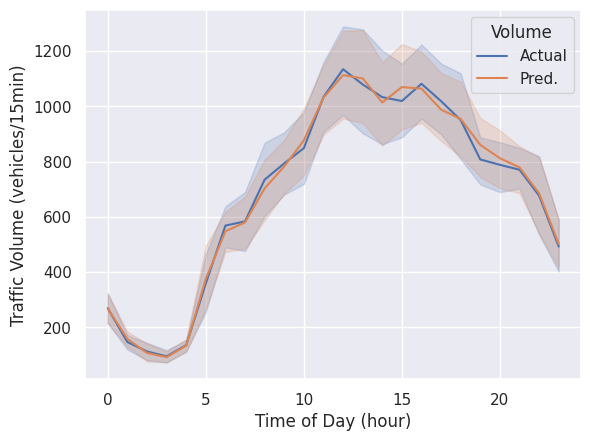

In [24]:
ax = sns.lineplot(data = pd.melt(data_dec[["hour","Actual","Pred."]], ["hour"]), x="hour", y="value", hue="variable")
ax.set(ylabel="Traffic Volume (vehicles/15min)", xlabel="Time of Day (hour)")
ax.get_legend().set_title("Volume")

plt.savefig("./plots/015_xgboost_predictions_per_date.eps", format="eps", bbox_inches="tight")
plt.savefig("./plots/015_xgboost_predictions_per_date.png", bbox_inches="tight")
plt.savefig("./plots/015_xgboost_predictions_per_date.pdf", bbox_inches="tight")

In [11]:
if not METRICS_DONE:
    ml_help.plot_prediction(y_test, y_pred, "XGBoost", "Vehicle Count", "015_xgboost_predictions")

## Random Forest

### Run CV

In [12]:
if not METRICS_DONE:
    from sklearn.ensemble import RandomForestRegressor
    
    params = ml_help.params_to_dict("013_random_forest")

In [13]:
if not METRICS_DONE:
    random_forest_pipeline = make_pipeline(StandardScaler(),RandomForestRegressor(**params))
    
    random_forest_cv_metrics = ml_help.run_stratified_kfold("Random Forest",random_forest_pipeline,X_train,y_train)
    random_forest_cv_metrics

### Test using previously unseen data

In [14]:
if not METRICS_DONE:
    random_forest_pipeline = make_pipeline(StandardScaler(),RandomForestRegressor(**params))

    start = time()
    pipe = random_forest_pipeline.fit(X_train,y_train)
    end = time()
    
    y_pred = pipe.predict(X_test)
    
    random_forest_metrics = ml_help.get_metrics_reg("Random Forest",y_test,y_pred)
    random_forest_metrics["time_to_fit"] = end-start
    random_forest_metrics

In [15]:
if not METRICS_DONE:
    ml_help.plot_prediction(y_test, y_pred, "Random Forest", "Vehicle Count", "015_random_forest_predictions")

## Decision Tree

### Run CV

In [16]:
if not METRICS_DONE:
    from sklearn.tree import DecisionTreeRegressor
    
    params = ml_help.params_to_dict("013_decision_tree")

In [17]:
if not METRICS_DONE:
    decision_tree_pipeline = make_pipeline(StandardScaler(),DecisionTreeRegressor(**params))
    
    dtr_cv_metrics = ml_help.run_stratified_kfold("Decision Tree",decision_tree_pipeline,X_train,y_train)
    dtr_cv_metrics

### Test using previously unseen data

In [18]:
if not METRICS_DONE:
    decision_tree_pipeline = make_pipeline(StandardScaler(),DecisionTreeRegressor(**params))
    
    start = time()
    pipe = decision_tree_pipeline.fit(X_train,y_train)
    end = time()
    
    y_pred = pipe.predict(X_test)
    
    dtr_metrics = ml_help.get_metrics_reg("Decision Tree",y_test,y_pred)
    dtr_metrics["time_to_fit"] = end-start
    dtr_metrics

In [19]:
if not METRICS_DONE:
    ml_help.plot_prediction(y_test, y_pred, "Decision Tree", "Vehicle Count", "015_decision_tree_predictions")

## MLP

### Run CV

In [20]:
if not METRICS_DONE:
    from sklearn.neural_network import MLPRegressor
    
    params = ml_help.params_to_dict("013_mlpr")

In [21]:
if not METRICS_DONE:
    mlp_pipeline = make_pipeline(StandardScaler(),MLPRegressor(**params))
    
    mlp_cv_metrics = ml_help.run_stratified_kfold("MLP",mlp_pipeline,X_train,y_train)
    mlp_cv_metrics

In [22]:
if not METRICS_DONE:
    mlp_pipeline = make_pipeline(StandardScaler(),MLPRegressor(**params))
    
    start = time()
    pipe = mlp_pipeline.fit(X_train,y_train)
    end = time()
    
    y_pred = pipe.predict(X_test)
    
    mlp_metrics = ml_help.get_metrics_reg("MLP",y_test,y_pred)
    mlp_metrics["time_to_fit"] = end-start
    mlp_metrics

In [23]:
if not METRICS_DONE:
    ml_help.plot_prediction(y_test, y_pred, "MLP", "Vehicle Count", "015_mlp_predictions")

# Store metrics

In [24]:
if not METRICS_DONE:
    metrics_cv = pd.concat([pd.DataFrame(xgb_cv_metrics,index=[0]),pd.DataFrame(random_forest_cv_metrics,index=[0]),pd.DataFrame(dtr_cv_metrics,index=[0]),pd.DataFrame(mlp_cv_metrics,index=[0])])
    metrics_cv.to_csv("./metrics/015_gardiner_count_only_cv_metrics.csv.zip",index=False,compression="zip")
    
    metrics = pd.concat([pd.DataFrame(xgb_metrics,index=[0]),pd.DataFrame(random_forest_metrics,index=[0]),pd.DataFrame(dtr_metrics,index=[0]),pd.DataFrame(mlp_metrics,index=[0])])
    metrics.to_csv("./metrics/015_gardiner_count_only_metrics.csv.zip",index=False,compression="zip")
else:
    metrics_cv = pd.read_csv("./metrics/015_gardiner_count_only_cv_metrics.csv.zip")
    metrics = pd.read_csv("./metrics/015_gardiner_count_only_metrics.csv.zip")

# Print CV metrics

In [25]:
sns.set_theme()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


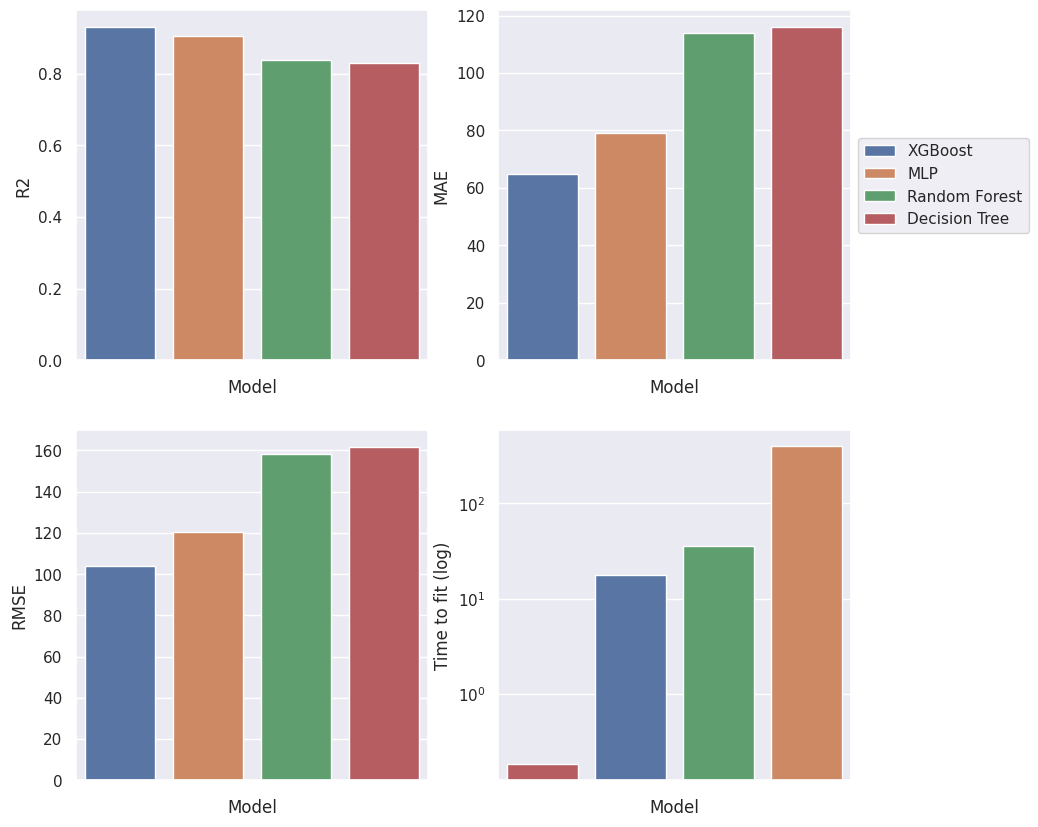

In [30]:
metrics_cv.sort_values(by="r2", ascending=False, inplace=True)
ttf_order_cv = list(metrics_cv.sort_values(by="time_to_fit")["model"])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(ax=axes[0, 0], data=metrics_cv, x='model', y='r2',hue="model",dodge=False)
sns.barplot(ax=axes[0, 1], data=metrics_cv, x='model', y='mae',hue="model",dodge=False)
# sns.barplot(ax=axes[0, 2], data=metrics_cv, x='model', y='mse',hue="model",dodge=False)
sns.barplot(ax=axes[1, 0], data=metrics_cv, x='model', y='rmse',hue="model",dodge=False)
# sns.barplot(ax=axes[1, 1], data=metrics_cv, x='model', y='mape',hue="model",dodge=False)
sns.barplot(ax=axes[1, 1], data=metrics_cv, x='model', y='time_to_fit',hue="model",dodge=False, order=ttf_order_cv)

axes[0, 0].set(xlabel="Model",xticklabels=[])
axes[0, 0].set(ylabel="R2")
axes[0, 0].get_legend().remove()

axes[0, 1].set(xlabel="Model",xticklabels=[])
axes[0, 1].set(ylabel="MAE")
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# axes[0, 2].set(xlabel="Model",xticklabels=[])
# axes[0, 2].set(ylabel="MSE")
# axes[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1, 0].set(xlabel="Model",xticklabels=[])
axes[1, 0].set(ylabel="RMSE")
axes[1, 0].get_legend().remove()

# axes[1, 1].set(xlabel="Model",xticklabels=[])
# axes[1, 1].set(ylabel="MAPE")
# axes[1, 1].get_legend().remove()

axes[1, 1].set(xlabel="Model",xticklabels=[])
axes[1, 1].set(ylabel="Time to fit (log)",yscale="log")
axes[1, 1].get_legend().remove()

plt.savefig("./plots/015_gardiner_count_only_cv_metrics.eps",format="eps",bbox_inches="tight")
plt.savefig("./plots/015_gardiner_count_only_cv_metrics.png",bbox_inches="tight")
plt.savefig("./plots/015_gardiner_count_only_cv_metrics.pdf",bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


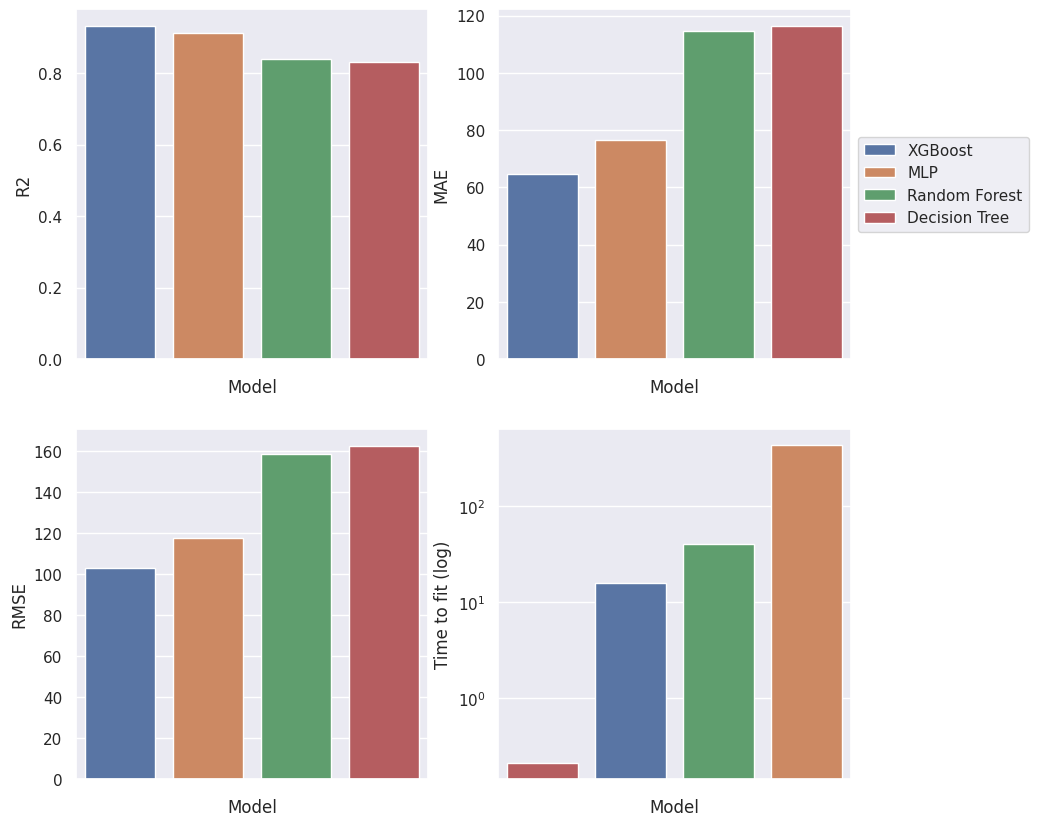

In [33]:
metrics.sort_values(by="r2", ascending=False, inplace=True)
ttf_order = list(metrics.sort_values(by="time_to_fit")["model"])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.barplot(ax=axes[0, 0], data=metrics, x='model', y='r2',hue="model",dodge=False)
sns.barplot(ax=axes[0, 1], data=metrics, x='model', y='mae',hue="model",dodge=False)
# sns.barplot(ax=axes[0, 2], data=metrics, x='model', y='mse',hue="model",dodge=False)
sns.barplot(ax=axes[1, 0], data=metrics, x='model', y='rmse',hue="model",dodge=False)
# sns.barplot(ax=axes[1, 1], data=metrics, x='model', y='mape',hue="model",dodge=False)
sns.barplot(ax=axes[1, 1], data=metrics, x='model', y='time_to_fit',hue="model",dodge=False, order=ttf_order)

axes[0, 0].set(xlabel="Model",xticklabels=[])
axes[0, 0].set(ylabel="R2")
axes[0, 0].get_legend().remove()

axes[0, 1].set(xlabel="Model",xticklabels=[])
axes[0, 1].set(ylabel="MAE")
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# axes[0, 2].set(xlabel="Model",xticklabels=[])
# axes[0, 2].set(ylabel="MSE")
# axes[0, 2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

axes[1, 0].set(xlabel="Model",xticklabels=[])
axes[1, 0].set(ylabel="RMSE")
axes[1, 0].get_legend().remove()

# axes[1, 1].set(xlabel="Model",xticklabels=[])
# axes[1, 1].set(ylabel="MAPE")
# axes[1, 1].get_legend().remove()

axes[1, 1].set(xlabel="Model",xticklabels=[])
axes[1, 1].set(ylabel="Time to fit (log)", yscale="log")
axes[1, 1].get_legend().remove()

plt.savefig("./plots/015_gardiner_count_only_metrics.eps",format="eps",bbox_inches="tight")
plt.savefig("./plots/015_gardiner_count_only_metrics.png",bbox_inches="tight")
plt.savefig("./plots/015_gardiner_count_only_metrics.pdf",bbox_inches="tight")

In [32]:
metrics

,model,r2,mae,mse,rmse,mape,time_to_fit
0,XGBoost,0.932328,64.778397,10596.979492,102.941635,3.687031e+15,16.107549
3,MLP,0.911549,76.450378,13850.723633,117.689095,4.258290e+15,435.986276
1,Random Forest,0.838758,114.536375,25249.306401,158.900303,5.676548e+15,40.697818
2,Decision Tree,0.830978,116.364922,26467.471636,162.688265,5.841025e+15,0.209941
